In [182]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import itertools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import torch_scatter
import math

[[-1.09100616  0.68133563]
 [ 0.46934693  1.38406629]
 [ 0.11935316 -0.455078  ]
 [ 1.50799207 -0.63683919]
 [ 0.39025905 -2.21271537]]
(5, 4, 2)


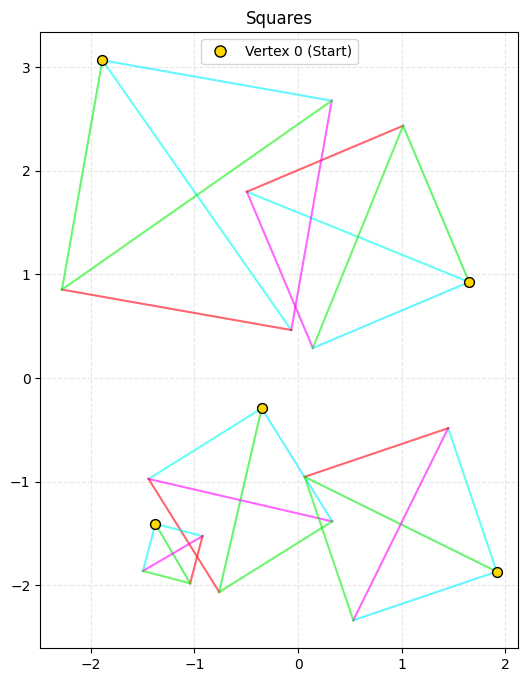

In [178]:
# Create a function for generating consistent 2d data, subject to rotations, reflections, and translations, and permutations (E(2) Equivariance)
def make_squares(size:int = 100):
    bottom = np.zeros((size,2))
    right = np.random.randn(size,2)
    print(right)
    left = np.column_stack((right[:,1],-right[:,0]))
    top = left+right
    # Build the squares via wide concatenation
    squares = np.concat((bottom, right, top, left), axis=1).reshape(size, 4, 2)
    return squares

def e2_augmentation(shapes):
    """
    Apply reflections (through x-axis), translations, permutations to training data.
    """
    size = shapes.shape[0]
    for i in range(size):
        # Reflections and Translations
        shapes[i,:] *= np.array([1, -1])
        shapes[i,:] += np.random.randn(1,2)

        # Permutations
        idx = np.argsort(np.random.rand(4))
        shapes[i,:] = shapes[i,idx]
    return shapes

def plot_quadrilaterals_dense(data, num_to_plot=20, title="Squares"):
    """
    Plots a dense graph (fully connected) for each set of points.
    """
    points = data.reshape(-1, 4, 2) if data.ndim == 2 else data
    limit = min(len(points), num_to_plot)

    fig, ax = plt.subplots(figsize=(8, 8))

    # Color configuration
    lc = ['00F','FF0','0FF','00F']
    vertex0_color = '#FFD700' # Gold
    
    for i in range(limit):
        sq = points[i]
        
        for p1_idx, p2_idx in itertools.combinations(range(4), 2):
            p1 = sq[p1_idx]
            p2 = sq[p2_idx]
            
            ax.plot(
                [p1[0], p2[0]], 
                [p1[1], p2[1]], 
                color= f"#{lc[p1_idx]}{lc[p2_idx]}", 
                linewidth=1.5, 
                alpha=0.6  # Lower alpha to handle the overlap gracefully
            )

        # Mark Vertex 0 for reference
        ax.scatter(sq[0, 0], sq[0, 1], color=vertex0_color, edgecolors='black', s=50, zorder=10)

    # Simplified Legend
    legend_elements = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=vertex0_color, markersize=8, markeredgecolor='k', label='Vertex 0 (Start)'),
    ]

    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_title(title)
    ax.legend(handles=legend_elements, loc='upper center')
    
    plt.show()

def plot_input_and_output_quads(input_quads: np.ndarray, output_quads: np.ndarray, title="Squarification"):
    assert input_quads.shape == output_quads.shape
    n = input_quads.shape[0]
    fig, ax = plt.subplots(figsize=(8,8))

    lc = ['00F','FF0','0FF','00F']
    v_color = '#FFD700'

    # Plot the inputs in Red
    for i in range(n):
        q = input_quads[i]

        for p1_idx, p2_idx in itertools.combinations(range(4),2):
            p1, p2 = q[p1_idx], q[p2_idx]

            ax.plot(
                [p1[0],p2[0]],
                [p1[1],p2[1]],
                color='red',
                linewidth=1.5,
                alpha=0.4 # Keep the originals relatively more translucent, like ghosts.
            )
        
        ax.scatter(q[0,0], q[0,1], color='gray', edgecolors=None, s=25, zorder=10)
    
    for i in range(n):
        sq = output_quads[i]
        for p1_idx, p2_idx in itertools.combinations(range(4), 2):
            p1, p2 = sq[p1_idx], sq[p2_idx]

            ax.plot(
                [p1[0], p2[0]],
                [p1[1], p2[1]],
                color = f"#{lc[p1_idx]}{lc[p2_idx]}",
                linewidth=1.5,
                alpha = 0.7
            )
        
        ax.scatter(sq[0, 0], sq[0, 1], color=v_color, edgecolors='black', s=50, zorder=10)
    
    legend_elements = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=4, markeredgecolor=None, label='Input'),
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=v_color, markersize=8, markeredgecolor='k', label='Model Output'),
    ]

    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.legend(handles=legend_elements, loc='upper center')


def plot_grid_comparisons(input_quads, output_quads, cols=4, title="Squarification Grid"):
    """
    Plots a grid of subplots, where each cell contains one Input (Red/Ghost) 
    overlaid with its corresponding Output (Colored).
    """
    assert input_quads.shape == output_quads.shape
    n = input_quads.shape[0]
    
    # Calculate grid dimensions
    rows = math.ceil(n / cols)
    
    # Create the figure with decent spacing
    # Adjust figsize: roughly 3.5 inches per column/row
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    
    # Flatten axes array for easy iteration (handles case where rows=1 or cols=1)
    axes = axes.flatten() if n > 1 else [axes]

    # Styling Constants
    lc = ['00F','FF0','0FF','00F'] # Your color map indices
    v_color = '#FFD700'             # Gold
    
    for i in range(len(axes)):
        ax = axes[i]
        
        # If we have run out of data samples, hide the empty subplot and continue
        if i >= n:
            ax.axis('off')
            continue
            
        # Get data for this window
        in_q = input_quads[i]
        out_q = output_quads[i]
        
        # --- PLOT INPUT (Red Ghost) ---
        for p1_idx, p2_idx in itertools.combinations(range(4), 2):
            p1, p2 = in_q[p1_idx], in_q[p2_idx]
            ax.plot(
                [p1[0], p2[0]], [p1[1], p2[1]],
                color='red', linewidth=1.5, alpha=0.3
            )
        # Input Vertex 0
        ax.scatter(in_q[0, 0], in_q[0, 1], color='gray', s=20, zorder=5, alpha=0.5)

        # --- PLOT OUTPUT (Model Prediction) ---
        for p1_idx, p2_idx in itertools.combinations(range(4), 2):
            p1, p2 = out_q[p1_idx], out_q[p2_idx]
            
            # Replicate your color logic
            # Note: This assumes lc contains hex snippets like '00F'
            edge_color = f"#{lc[p1_idx]}{lc[p2_idx]}" 
            
            ax.plot(
                [p1[0], p2[0]], [p1[1], p2[1]],
                color=edge_color, linewidth=2.0, alpha=0.9
            )
        # Output Vertex 0
        ax.scatter(out_q[0, 0], out_q[0, 1], color=v_color, edgecolors='black', s=60, zorder=10)

        # Formatting per subplot
        ax.set_aspect('equal')
        ax.set_xticks([]) # Remove ticks for cleaner look
        ax.set_yticks([])
        ax.set_title(f"Sample {i}", fontsize=9, color='#555555')

    # Create a single global legend at the top of the figure
    legend_elements = [
        mlines.Line2D([0], [0], color='red', linewidth=1.5, alpha=0.4, label='Input (Start)'),
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, label='Input Vertex 0'),
        mlines.Line2D([0], [0], color='blue', linewidth=2.0, label='Output (Square)'),
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=v_color, markeredgecolor='k', markersize=8, label='Output Vertex 0'),
    ]
    
    fig.suptitle(title, fontsize=16, y=1.02)
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, frameon=False)
    
    plt.tight_layout()
    plt.show()
squares = e2_augmentation(make_squares(size=5))
print(squares.shape)
plot_quadrilaterals_dense(squares)

### Can we train a neural network to *generate squares*?
Yes, we can.
# Enter: The E(2) Equivariant Diffusion Model!
### Hold on, what's E(2)? Also what's equivariance? And what's a diffusion model?
#### 1. Diffusion Models (DDPM)
Okay, so let's start with the basics. A **Diffusion Model** (Denoising Diffusion Probabalistic Model, or DDPM) is a neural-network model which is trained to generate 'clean' data from 'noisy' data. There's a lot of math underlying the architecture of DDPMs, which is beautifully explained in this video by Welch Labs (), but I'm not going into detail about that right now. For now, I want to focus on the **Equivariant** part of the equation. So..

#### 2. Invariance
Invariance in this context means **invariance over group actions** within a symmetry group. See **Group theory** for a more detailed description. Essentially, for all actions **A(x)** in group **g**, an **invariant function *f*** returns the same output: f(x) = f(A(x)). For example:
```
f(]) = f([) = *
f(<) = f(>) = &
f(\) = f(/) = %
```
describes a function which is invariant to vertical reflections of the input.
#### 3. Equivariance
This concept is only slightly more complex. It says that performing action **A** on the ***output*** of **f(x)** is the same as performing that action on its **input**: A(f(x)) = f(A(x)). Equivariance essentially means that as you change the input, the output changes accordingly. For example:

```
nums(A,B,C,D) = {1,2,3,4}
nums(B,C,D,A) = {2,3,4,1}
nums(C,D,B,A) = {3,4,2,1}, etc.
```
is an example of a ***permutation-equivariant*** function.
***E(2)***
refers to a specific action group: The set of all rigid-body transformations in 2D space (rotations, reflections, translations). So, *E(2) equivariance* describes a model which makes predictions which are equivariant across all rigid body transformations.


### Why I'm trying to generate squares using *E(2) Equivariant EGNNs*
The ultimate goal of my model is to be able to generate climbs in 3-dimensional space, in such a way that the final probability distribution is **E(3) Invariant**. It's essentially a more complex version of the above challenge. The goal is to generate a climb as a **point cloud**, which has a few distinct features from other types of data:
1. **Coordinate Basis**: Point clouds are fundamentally groups of **nodes** (or coordinate points) with some extra data attached to each node. Think *atoms in a molecule*, or *birds in a simulated flock*. The fundamental unit of data in the point cloud is the *point*.
2. **Permutation Invariance**: As the name implies, point clouds are **unordered**, meaning that [[0, 0],[1, 1],[2, 2],[3, 3]] and [[1, 1],[2, 2],[0, 0],[3, 3]] describe the same fundamental object. Essentially, as long as you can map coordinatees in one point cloud 1:1 with coordinates in another, then the two point clouds are identical. However, matching nodes must be identical, and that includes whatever additional data is attached to each node. For example, if the goal-keeper and the center striker on a soccer team swap places, then the point cloud describing the team's position *has changed*, even if the 'set of coordinates' is the same. This is because two coordinates have effectively swapped information (The coordinate formerly containing 'center striker' now contains 'goalkeeper').
3. 
### The goal of an EGNN Diffusion Model is to generate point clouds with an *additional symmetry*, E(2) Invariance.
This means that my model should be able to generate squares in *any orientation*, i.e. reflection, rotation, and translation. And for the final distribution to be *Invariant* over an action group, the denoising function must be *equivariant*. Why?
1. If you think of the final distribution as being a **PDF**, the diffusion model needs to take data located at some random point in space and move it **upslope** towards points of greater likelihood. In order to do that, it needs to know the *direction* in which the denser regions lie relative to the starting point. This is not **invariance**, but **equivariance**. For example, if the target distribution is **permutation invariant**, then [p1, p2, p3, p4] and [p4, p2, p1, p3] should be **equally likely**: that's **invariance**. However, the direction in which our model updates the noisy data [p1'->p1, p2'->p2, p3'->p3, p4'->p4] *should depend on the points' order*.
```
f(p1', p2', p3', p4') = [p1, p2, p3, p4]
f(p2', p3', p1', p4') = [p2, p3, p1, p4], not [p1, p2, p3, p4]
```
Invariant outcomes require equivariant transformations.

### How to build an Equivariant Graph Neural Network

The main architecture previously used for equivariant updates (specifically *permutation equivariance*) is the **equivariant graph neural network (EGNN)**. An EGNN is based on the concept of encoding a set of points as a connected graph, and using **message-passing** to update the features of each point in the graph. 

Here's the message passing algorithm in a nutshell (Assuming our model is updating a dense graph with nodes *A,B,C,D*):

1. Compile a list of all the directed "edges" in the graph. E.g. A->B, B->C, etc. Note that A->B and B->A are *different* edges.
2. For each edge, compose a "Message" by combining the features of both points (and features of the edge itself, if there are any) using a neural network, $\Phi$.
3. Send the messages to the destination node, and aggregate them into a single "update message" for that node. So node **A** would decide on how to update its' values by somehow combining messages **{B->A, C->A, D->A}**.
4. Optionally, we can repeat this process, composing new messages using the updated values stored by each node.

So long as our **aggregation function** is *permutation invariant* (e.g. ***sum**, **mean**, **max**, **min***), our node value updates will be permutation equivariant. In effect, each node will recieve the same update regardless of its "position" in our embedded feature vector.
```
EGNN(A,B,C,D) -> {A',B',C',D'}, EGNN(B,C,A,D) -> {B',C',A',D'}
```

For the purposes of simulating squares, we're going to build a diffusion model called **GenerateSquares** which employes an **EGNN** as its tool for the denoising step.

### E(d) EGNNs
Now, our **GenerateSquares** model needs to include an *additional* form of equivariance; E(2) equivariance. To achieve *that*, we must ensure that the messages which get passed along the node edges are themselves *E(2) invariant*. How can we do this? well, given two points A and B, there is one class of mathematical functions which are informative, yet invariant to rigid-body transformations: **Distance Metrics**.

$$SquaredEuclideanDistance (A, B) = ||A-B||_2^2 = \sum_{i=1}^d (A_i-B_i)^2$$

where $d$ is the number of spatial featuers (dimensions) our datapoints occupy. Squared Euclidean Distance is going to be the bedrock of our message-building function. We'll construct messages like so:
$$\Phi(A, B) = NN(h_a, h_b,||n1-n2||_2^2, h_e)$$
where $h_a$ and $h_b$ refer to the "scalar features" of nodes A and B. These are *non-spatial features* (E.g. if we were using this model for molecule construction, these would be atom-specific properties such as ***mass, charge, and element-type***). As a result, we can use them directly in the network.

Note that if we were to include the exact *coordinates* of either *A* or *B* in this message construction, we would *lose* E(d) Equivariance. Why? Well, there's no guarantee that, for example, $NN([0,0],[1,1],...)$ will return the same result as its reflection over the x-axis, $NN([0,0],[-1,-1],...)$. To guarantee E(d) Equivariance, we cannot use spatial features *directly*. However, we made no such guarantees about *non-spatial features*, so they're fair game.

### The E2_EGNN Layer for *Squares*

In [129]:
class E2_EGNN(nn.Module):
    """Equivariant Graph Neural Network layer"""

    def __init__(self, emb_dim, hidden_dim, activation_func = nn.ReLU()):
        super().__init__()
        # h_i + h_j + dist_squared (size 1)
        message_dim = emb_dim * 2 + 1
        coord_input_dim = hidden_dim 
        # Coordinate updates are a scalar force applied along the edge being used to build the edge message
        coord_update_dim = 1 
        # h_n + aggregated message functions (size hidden_dim)
        feature_input_dim = emb_dim + hidden_dim 

        self.msg_mlp = nn.Sequential(
            nn.Linear(message_dim, hidden_dim),
            activation_func,
            nn.Linear(hidden_dim, hidden_dim),
            activation_func
        )

        self.coord_mlp = nn.Sequential(
            nn.Linear(coord_input_dim, hidden_dim),
            activation_func,
            nn.Linear(hidden_dim, coord_update_dim)
        )

        self.node_mlp = nn.Sequential(
            nn.Linear(feature_input_dim, hidden_dim),
            activation_func,
            nn.Linear(hidden_dim, emb_dim)
        )

    def coord2radial(self, edge_index, coord):
        """Radial is squared Euclidean distance, fyi"""
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        return radial, coord_diff/torch.sqrt(radial + 1e-8)

    def forward(self, x, h, edge_index):
        """
        Forward pass
        
        :param h: Scalar features
        :param x: Position (Vector) features (Equivariant over these)
        :param edge_index: Edge indices for all edges in the graph: [[n1, n2] x # edges]
        """

        n1, n2 = edge_index

        squared_dist, norm_coord_diff = self.coord2radial(edge_index, x)
        msgs = self.msg_mlp(torch.cat([h[n1], h[n2], squared_dist],dim=1))

        # Update x based on aggregated coordinate updates
        coord_updates = norm_coord_diff * self.coord_mlp(msgs)
        x_new = x + torch_scatter.scatter(coord_updates, n1, dim=0, reduce='sum', dim_size=x.size(0))
        
        feature_updates = torch_scatter.scatter(msgs, n1, dim=0, reduce='sum', dim_size=h.size(0))
        h_new = h + self.node_mlp(torch.cat([feature_updates, h], dim=1))

        return x_new, h_new

### Testing the Raw EGNN

Now that we've built the EGNN layer, lets put it into a model and test the model on a dataset of graphs: In this case, quadrilaterals.

1. An **Embedding Model**, $E(h)$ Which embeds non-spatial node features into the **Embedding Dimension** of my EGNN. Since the points in my squares currently *have no non-spatial features*, I will initialize them with a generic vector of spatial features, all set to 1.
2. A stack of **EGNN** layers which update my points spatial and non-spatial features using the message passing process. The final output of this stack of layers should be the finished product, i.e. normalized squares.

Here's the model:

In [148]:
class SquareModel(nn.Module):
    def __init__(self, n_nodes=4, n_layers=4, emb_dim = 64):
        super().__init__()
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.n_nodes = n_nodes

        # Bidirectional edge indices
        edges = [[a, b,] for a in range(n_nodes) for b in range(n_nodes) if a !=b ]
        self.edge_index = torch.tensor(edges, dtype=torch.long).t()
        
        self.egnn_trunk = nn.ModuleList([E2_EGNN(hidden_dim=emb_dim,emb_dim=emb_dim) for _ in range(n_layers)])

    def get_batched_edges(self, batch_size):
        num_edges = self.edge_index.size(0)
        batches = []

        # Add the edge connections for all of the indices in the next graph in the batch. It should just be the previous node indices + n_nodes.
        for i in range(batch_size):
            batches.append(self.edge_index + i*self.n_nodes)

        return torch.cat(batches, dim=1)

    def forward(self, x):

        batch_size = x.size(0)
        x_flat = x.view(-1,2)

        edge_index = self.get_batched_edges(batch_size)

        # Initial hidden state embeddings
        h = torch.ones(x_flat.size(0),self.emb_dim, device = x.device)
        for layer in self.egnn_trunk:
            x_flat, h = layer(x_flat, h, edge_index)
        return x_flat.view(-1, 4, 2)

### Defining the loss function.

Okay, the last major mathematical hurdle we face when training this model is defining our loss function. Essentially, how can we encode the **"Squariness"** of out model's output into a number, and penalize the model for poor squares? My first thought was to minimize the variance between edge-lengths:

$$Loss = EdgeVariance(n) = \sum_{i,j\in n;i \neq j} (d_{ij}-\mu_d)^2$$

where $n$ is a dense node graph, $d_ij$ is the length of edge $i\rightarrow j = ||n_i-n_j||_2^2$, and $\mu_d$ is the mean edge length. This is because in 2 dimensions, the shape which minimizes the variance in edge-length is a square!

However this metric has a bit of a problem... You see, while a square minimizes this metric for a **given total edge length** (e.g. $6$), there is a much simpler way to reduce the edge-lenght variance down to zero:
##### **shrinking the quadrilateral down into a single point**.

To fix this, we can normalize the variance by dividing by mean edge length squared, $\mu_e^2$:

$$ Loss = \frac{EdgeVariance(n)}{\mu_e^2} = \sum_{i,j \in n; i \neq j} \frac{(d_{i,j}-\mu_d)^2}{\mu_d^2}$$

This is better: Now our loss function is *scale invariant*. In other words, our model should have no preference for generating smaller or larger squares. However, there is one final issue to address. Because our model is **completely ambivalent** about the scale of the squares it produces, it has ***no incentive to keep the generated squares at a reasonable scale***. For example, it might settle upon a solution which generates squares with side lengths of $10,000,000$, or conversely, $10^{-9}$. To address this, we'll add a normalization parameter, $\epsilon = ln(\mu)^2$, which should give the model a slight preference for squares with reasonable side-lengths.

$$ Loss = \sum_{i,j \in n; i \neq j} \frac{(d_{i,j}-\mu_d)^2}{\mu_d^2}+ ln(\mu)^2 $$

#### Awesome!

Now let's build the trainer in **torch**

In [126]:
class SquareModelTrainer:
    def __init__(self, model):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    def get_loss(self, batch):
        """
        Loss function for my Square-Generating model
        
        :param batch: Batched Quadrilateral input data.
        """
        # cdist returns (Batch, 4, 4) distance matrix
        dists_matrix = torch.cdist(batch, batch)
        
        # Extract unique edges. For 4 nodes, upper triangle indices:
        # (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)
        unique_edges = torch.triu_indices(4, 4, offset=1)
        edge_lengths = dists_matrix[:, unique_edges[0], unique_edges[1]] # (Batch, 6)
        
        # Calculate stats per graph
        mu = edge_lengths.mean(dim=1)     # (Batch,)
        var = edge_lengths.var(dim=1, unbiased=False) # (Batch,)
        
        # Loss per graph
        loss_per_graph = (var / (mu**2 + 1e-6)) + torch.log(mu)**2
        
        return loss_per_graph.mean()
    
    def train_step(self, batch):
        """A single step in the training process"""

        self.optimizer.zero_grad()
        x_pred = self.model(batch)
        loss = self.get_loss(x_pred)
        loss.backward()

        self.optimizer.step()
        return loss.item(), x_pred

### Generating Training data (Random Quadrilaterals)
Now let's generate our training data. This process is *relatively* simple. We can generate a dataset of quadrilaterals by just picking each point randomly. However, I like the variation that I get by running my shapes through my augmentation function, and I wrote the damn thing so I might as well use it.

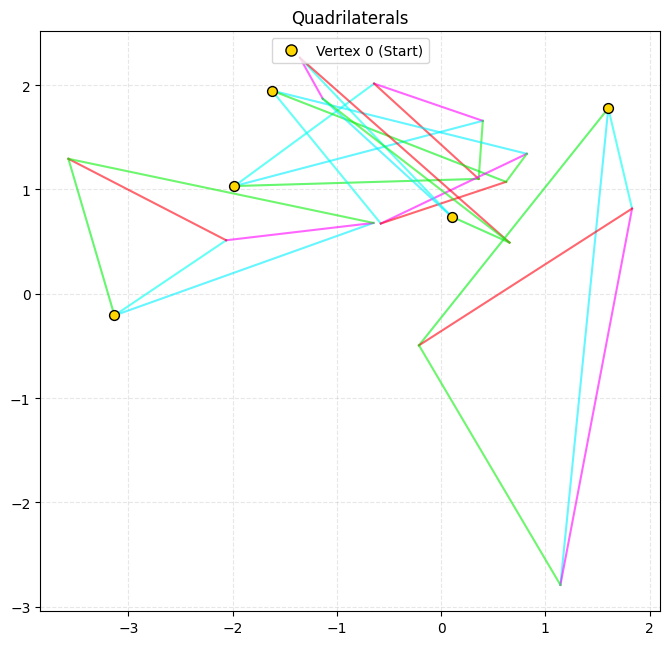

In [121]:
quads = e2_augmentation(np.random.randn(10000,4,2))
plot_quadrilaterals_dense(quads[:5], title="Quadrilaterals")

#### Nice! That is some suitably messy data!
Now let's train the model.

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(quads, batch_size=64, shuffle=True)

model = SquareModel().to(device)
trainer = SquareModelTrainer(model)

print(f"Training on {device}...")

losses = []
for epoch in range(20): # Train for 20 epochs
    epoch_loss = 0
    for batch in dataloader:
        batch = batch.to(device, dtype=torch.float)
        loss, pred = trainer.train_step(batch)
        epoch_loss += loss
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

Training on cpu...
Epoch 0: Loss = 0.091749
Epoch 2: Loss = 0.043938
Epoch 4: Loss = 0.036318
Epoch 6: Loss = 0.048651
Epoch 8: Loss = 0.034348
Epoch 10: Loss = 0.032609
Epoch 12: Loss = 0.032125
Epoch 14: Loss = 0.050454
Epoch 16: Loss = 0.036208
Epoch 18: Loss = 0.032941


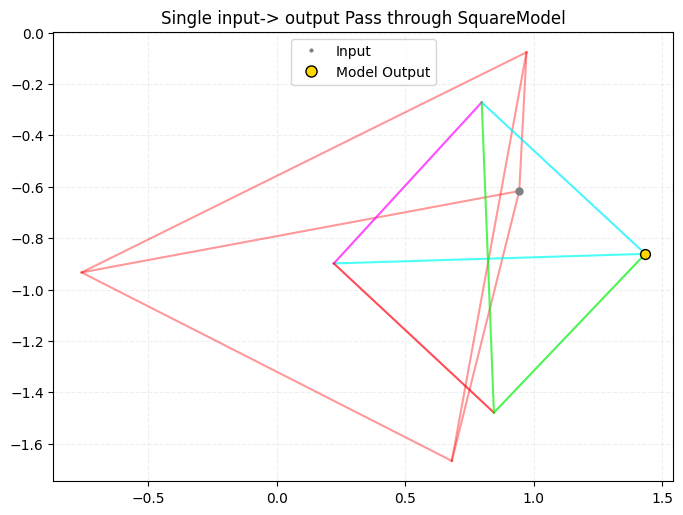

In [180]:
test_quads = torch.randn(100,4,2)
model.eval()
with torch.no_grad():
    output = model(test_quads).detach().numpy()

plot_input_and_output_quads(test_quads.numpy()[:1], output[:1], title="Single input-> output Pass through SquareModel")

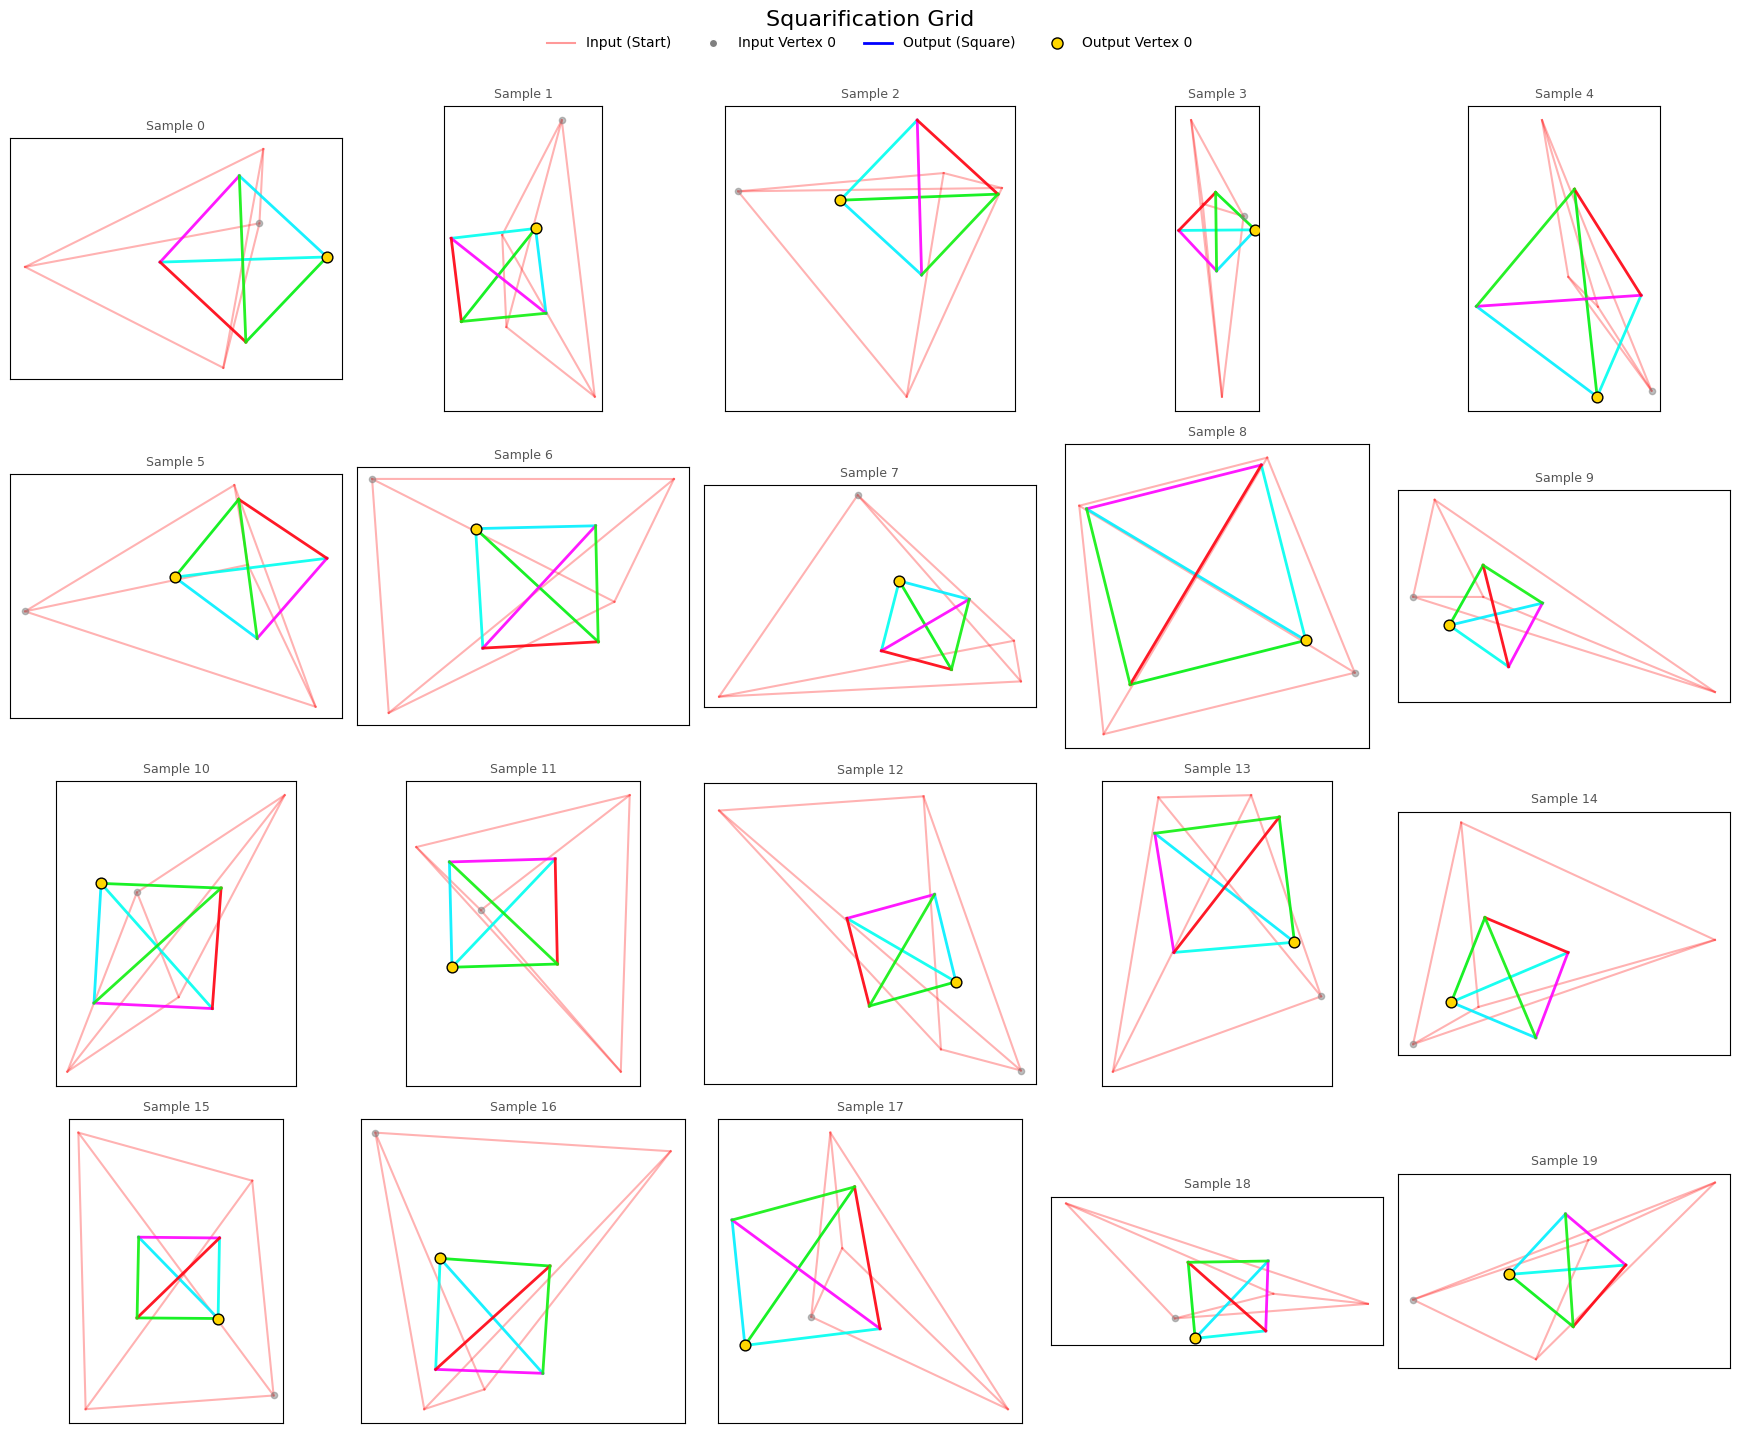

In [186]:
plot_grid_comparisons(test_quads.numpy()[:20], output[:20], cols=5)